<a href="https://colab.research.google.com/github/Raanank10/Detecting-Parkinson-s-Disease/blob/080821/Detecting_Parkinsons_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Parkinsons Disease

In [312]:
pip install catboost

In [313]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# catboost
from catboost import CatBoostClassifier, CatBoostRegressor

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version
import re

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [314]:
url = 'https://raw.githubusercontent.com/Raanank10/Detecting-Parkinson-s-Disease/main/parkinsons.csv'

data = pd.read_csv(url)
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [315]:
trainSize = 0.70
randState = 990

# EDA

In [316]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

## Data Cleaning

In [317]:
data.nunique()

name                195
MDVP:Fo(Hz)         195
MDVP:Fhi(Hz)        195
MDVP:Flo(Hz)        195
MDVP:Jitter(%)      173
MDVP:Jitter(Abs)     19
MDVP:RAP            155
MDVP:PPQ            165
Jitter:DDP          180
MDVP:Shimmer        188
MDVP:Shimmer(dB)    149
Shimmer:APQ3        184
Shimmer:APQ5        189
MDVP:APQ            189
Shimmer:DDA         189
NHR                 185
HNR                 195
status                2
RPDE                195
DFA                 195
spread1             195
spread2             194
D2                  195
PPE                 195
dtype: int64

In [318]:
unique_data = data.drop_duplicates(inplace=False)
unique_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [319]:
data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


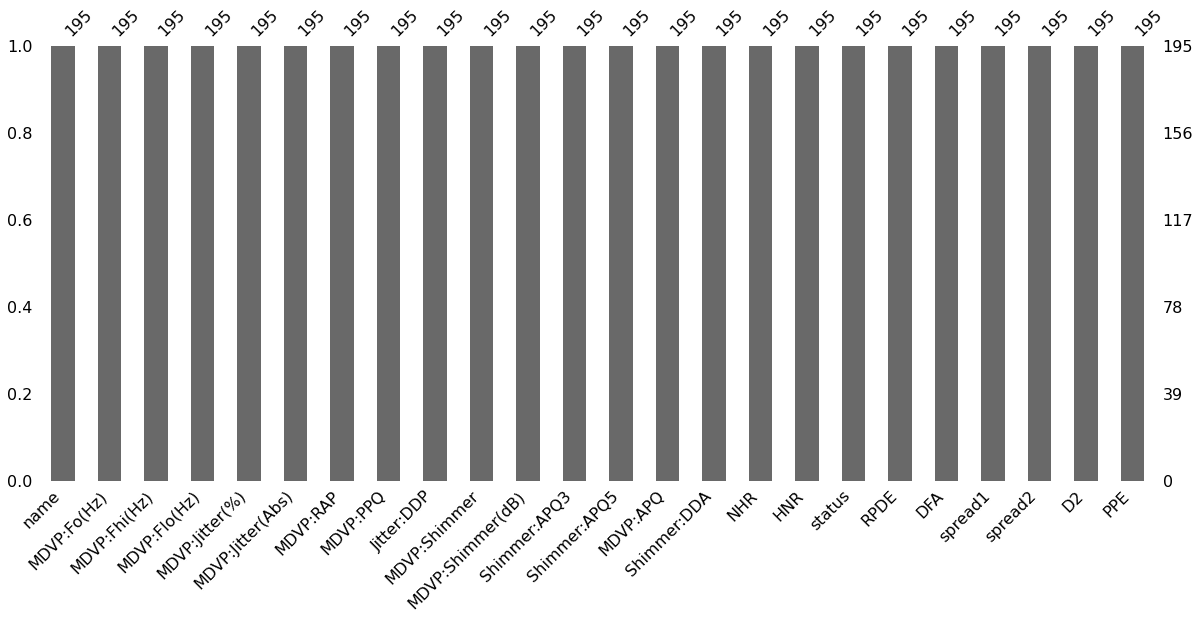

In [320]:
msno.bar(data, figsize=(20, 8))

## Preprocessing

In [321]:
data.corr()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,-0.094717,-0.070682,-0.077774,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,-0.003743,-0.009997,0.004937,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,-0.150747,-0.101095,-0.107293,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,0.746625,0.725561,0.758255,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,0.697153,0.648961,0.648793,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,0.744912,0.709927,0.737455,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,0.763580,0.786780,0.804139,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,0.744894,0.709907,0.737439,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,0.987625,0.982835,0.950083,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,0.963198,0.973751,0.960977,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


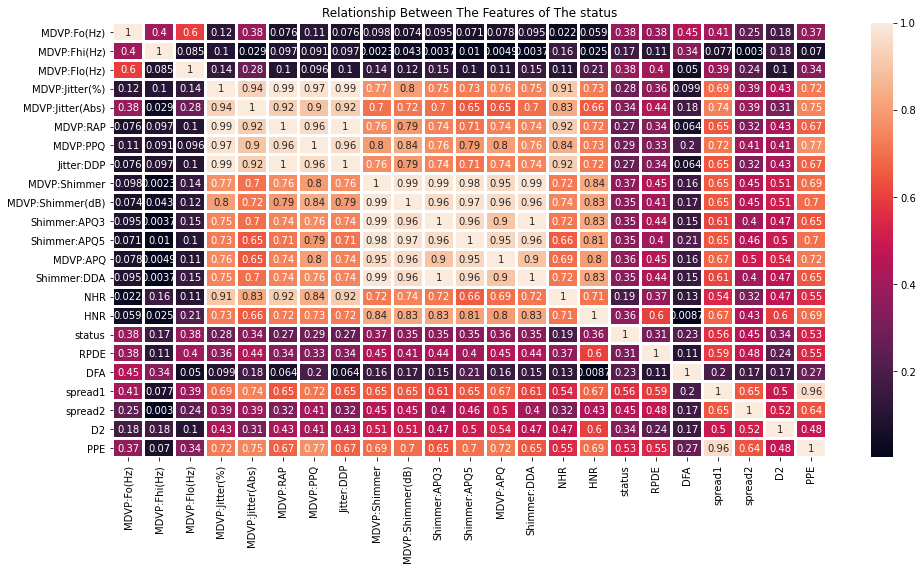

In [322]:
plt.figure(figsize=(16,8))
plt.title("Relationship Between The Features of The status")
sns.heatmap(data.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [323]:
fig = px.histogram(data, x='spread1', title='Distribution of spread1', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [324]:
fig = px.histogram(data, x='spread2', title='Distribution of spread2', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [325]:
fig = px.histogram(data, x='PPE', title='Distribution of PPE', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [326]:
data.status.value_counts()

1    147
0     48
Name: status, dtype: int64

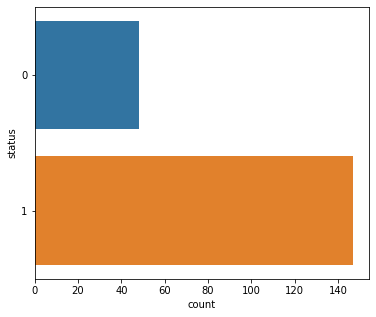

In [327]:
fig , ax = plt.subplots(figsize = (6,5))
ax = sns.countplot(y= 'status', data = data)

In [328]:
enc = OrdinalEncoder()

In [329]:
enc.fit(unique_data[['name']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [330]:
data['name_as_number'] = enc.transform(data[['name']])
data = data.drop('name', axis=1)

# Spliting the Data

In [331]:
X = data.drop('status', axis=1)
y = data.status

# MinMaxScaler
X = MinMaxScaler().fit_transform(X)

X = pd.DataFrame(X)

X_train,X_test,y_train,y_test=train_test_split(X, y, train_size = trainSize, \
      random_state = randState, stratify = data.status)

In [332]:
print('train_df shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('X_train shape :',y_train.shape)
print('test_df shape :',y_test.shape)

train_df shape : (136, 23)
X_test shape : (59, 23)
X_train shape : (136,)
test_df shape : (59,)


# Different predictions models

# Model 1 Decision Tree unbalanced Data

In [333]:
t1 = time()
dt_model_1 = DecisionTreeClassifier().fit(X_train, y_train)
t2 = time()
print(f"DecisionTree unbalanced took {t2-t1:.2f} seconds")

DecisionTree unbalanced took 0.00 seconds


In [334]:
def visualize_tree(model, md=10, width=800):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md, label='none')
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=width) 

In [335]:
def print_dot_text(model, md=5):
    """The output of this function can be copied to http://www.webgraphviz.com/"""
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    dot_text = dot_data.getvalue()
    print(dot_text)

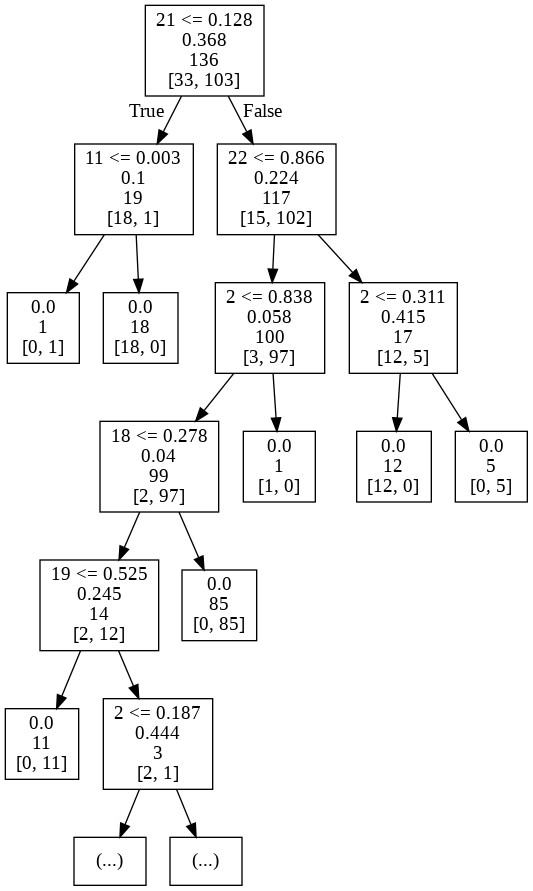

In [336]:
visualize_tree(dt_model_1, md=5, width=600)

In [337]:
pd.Series(dt_model_1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

21    0.438863
22    0.265579
2     0.205920
19    0.041917
11    0.037906
18    0.009815
17    0.000000
7     0.000000
1     0.000000
20    0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
8     0.000000
16    0.000000
9     0.000000
10    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
0     0.000000
dtype: float64

In [338]:
dt_model_1.tree_.max_depth

6

In [339]:
dt_model_1.feature_importances_

array([0.        , 0.        , 0.20591986, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03790589, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0098153 , 0.04191709,
       0.        , 0.4388633 , 0.26557856])

### Evaluate the model

In [340]:
X_test_pred = X_test.copy()

X_test_pred['y_pred'] = dt_model_1.predict(X_test)
X_test_pred['y_train'] = y_test
X_test_pred.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
54,0.119193,0.066365,0.215310,0.188374,0.249012,0.135356,0.211147,0.135174,0.161128,0.139688,0.197997,0.140977,0.103224,0.198100,0.030907,0.511542,0.652010,0.975076,0.599429,0.448617,0.250732,0.563681,0.278351,1,1
116,0.406853,0.694881,0.037261,0.097840,0.090909,0.070328,0.061629,0.070316,0.046011,0.051767,0.029083,0.024016,0.045409,0.029144,0.047395,0.728074,0.453189,0.316889,0.346007,0.601068,0.541629,0.260066,0.597938,1,1
141,0.697145,0.309556,0.151565,0.187103,0.130435,0.173410,0.180064,0.173543,0.526840,0.399343,0.685863,0.465807,0.286775,0.685775,0.132826,0.292896,0.816121,0.365183,0.461882,0.636269,0.552455,0.387683,0.726804,1,1
52,0.230934,0.073297,0.325883,0.085133,0.090909,0.033237,0.039657,0.033232,0.122604,0.102712,0.167180,0.068114,0.073359,0.167223,0.013241,0.660449,0.474113,0.764611,0.161376,0.482105,0.244236,0.154856,0.268041,1,0
55,0.125323,0.049426,0.224308,0.224269,0.288538,0.158960,0.239550,0.158773,0.205861,0.182416,0.256934,0.192944,0.132859,0.257029,0.035490,0.500935,0.704688,0.946436,0.656567,0.485015,0.263058,0.621950,0.283505,1,1
0,0.184308,0.112592,0.054815,0.195680,0.249012,0.145472,0.247588,0.145288,0.312215,0.280197,0.332627,0.347354,0.172448,0.332584,0.068307,0.511745,0.369155,0.960148,0.569875,0.585765,0.390661,0.497310,0.000000,1,1


In [341]:
X_test_pred['que'] = np.where((X_test_pred['y_pred'] == X_test_pred['y_train'])\
                     , 'yes', 'no')
X_test_pred['que'].value_counts()

yes    55
no      4
Name: que, dtype: int64

In [342]:
preds_1= dt_model_1.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_1)

0.8886363636363638

In [343]:
log_loss(y_test, preds_1)

2.341652616473447

In [344]:
accuracy_score(y_true=y_test, y_pred= preds_1)

0.9322033898305084

Text(0.5, 15.0, 'Predicted label')

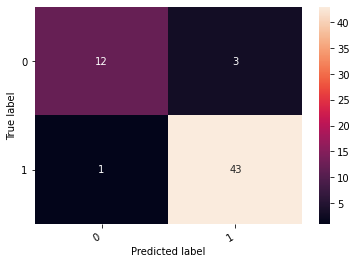

In [345]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred.y_pred)
DT_model_cm = pd.DataFrame(cm, index=dt_model_1.classes_, columns=dt_model_1.classes_)
hmap = sns.heatmap(DT_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [346]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred.y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.93      0.98      0.96        44

    accuracy                           0.93        59
   macro avg       0.93      0.89      0.91        59
weighted avg       0.93      0.93      0.93        59



In [347]:
my_cv = StratifiedShuffleSplit(n_splits = 26, train_size = 0.75, random_state = randState) 

In [348]:
-cross_val_score(dt_model_1, X_train, y_train, cv=my_cv, scoring='accuracy') 

array([-0.94117647, -0.91176471, -1.        , -0.82352941, -0.91176471,
       -0.82352941, -0.91176471, -0.97058824, -0.82352941, -0.88235294,
       -0.94117647, -0.94117647, -0.94117647, -0.85294118, -0.97058824,
       -0.91176471, -0.82352941, -0.79411765, -0.94117647, -0.94117647,
       -0.97058824, -0.97058824, -0.91176471, -0.97058824, -0.97058824,
       -0.97058824])

In [349]:
dt_model_1_gs = DecisionTreeClassifier(min_samples_leaf=40, min_weight_fraction_leaf=0.01)

In [350]:
# %%timeit
-cross_val_score(dt_model_1_gs, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([1.32086488, 0.41157628, 0.42889437, 0.44237675, 0.4524446 ,
       0.32066603, 0.48117396, 0.55267779, 0.48726548, 0.33748623,
       1.32086488, 1.32086488, 0.33748623, 0.39559348, 0.75436653,
       0.48432024, 0.55267779, 0.48117396, 0.44367814, 0.48737861,
       0.50320075, 1.30194413, 1.38534172, 0.47576359, 0.33748623,
       0.48877126])

In [351]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [352]:
dt_model_gs = GridSearchCV(estimator=dt_model_1_gs, param_grid=my_param_grid,\
                           cv=my_cv, scoring='neg_log_loss')

In [353]:
# %%timeit
dt_model_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=26, random_state=990, test_size=None,
            train_size=0.75),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min_weigh...leaf=0.01,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='

In [354]:
print("Best parameters:", dt_model_gs.best_params_)

Best parameters: {'criterion': 'gini', 'min_impurity_decrease': 1e-05, 'min_samples_leaf': 60, 'min_weight_fraction_leaf': 0.01}


In [355]:
dt_model_gs_2 = dt_model_gs.best_estimator_

In [356]:
y_test_pred_gs_2 = pd.DataFrame(dt_model_gs_2.predict_proba(X_test),\
                           columns=dt_model_gs_2.classes_)

In [357]:
log_loss(y_true=y_test, y_pred=y_test_pred_gs_2)

0.5270947102736097

In [358]:
X_test_pred_2 = X_test.copy()

X_test_pred_2['y_pred'] = dt_model_gs_2.predict(X_test)
X_test_pred_2['y_train'] = y_test
X_test_pred_2.sample(6)

roc_auc_score(y_test,X_test_pred_2.y_pred)

0.5

In [359]:
log_loss(y_test, X_test_pred_2.y_pred)

8.781248133645986

In [360]:
accuracy_score(y_true=y_test, y_pred= X_test_pred_2.y_pred)

0.7457627118644068

Text(0.5, 15.0, 'Predicted label')

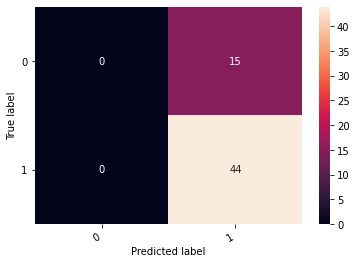

In [361]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred_2.y_pred)
DT_model_cm = pd.DataFrame(cm, index=dt_model_1.classes_, columns=dt_model_1.classes_)
hmap = sns.heatmap(DT_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [362]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_2.y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.75      1.00      0.85        44

    accuracy                           0.75        59
   macro avg       0.37      0.50      0.43        59
weighted avg       0.56      0.75      0.64        59



# Model 2 Decision Tree balanced Data

In [363]:
t1 = time()
dt_model_bal = DecisionTreeClassifier(class_weight = 'balanced',min_samples_leaf=40,\
                                    min_weight_fraction_leaf=0.01).fit(X_train, y_train)
t2 = time()
print(f"DecisionTree balanced took {t2-t1:.2f} seconds")

DecisionTree balanced took 0.00 seconds


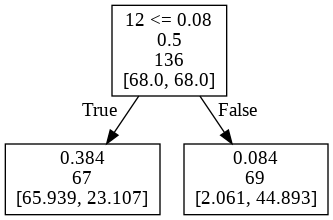

In [364]:
visualize_tree(dt_model_bal, md=5, width=600)

In [365]:
pd.Series(dt_model_bal.feature_importances_,\
          index=X_train.columns).sort_values(ascending=False)

12    1.0
22    0.0
10    0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
21    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
0     0.0
dtype: float64

### Evaluate the model

In [366]:
X_test_pred_bal = X_test.copy()

X_test_pred_bal['y_pred'] = dt_model_bal.predict(X_test)
X_test_pred_bal['y_train'] = y_test
X_test_pred_bal.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
92,0.348945,0.128283,0.442289,0.092440,0.090909,0.087669,0.087889,0.087655,0.295417,0.244864,0.371341,0.264722,0.178574,0.371421,0.058853,0.420182,0.461696,0.638319,0.363938,0.183617,0.409743,0.293997,0.474227,1,1
183,0.168206,0.044459,0.237084,0.079098,0.130435,0.056840,0.095391,0.056831,0.087183,0.070666,0.078775,0.088602,0.094188,0.078829,0.028329,0.594896,0.809520,0.379604,0.424143,0.417141,0.268673,0.354547,0.943299,1,0
140,0.477581,0.340184,0.080987,0.128018,0.090909,0.078998,0.094855,0.078985,0.211703,0.161052,0.242296,0.189145,0.161192,0.242329,0.077028,0.410428,0.981287,0.441324,0.572802,0.881266,0.685321,0.481927,0.721649,1,1
67,0.283143,0.131586,0.003040,0.239835,0.249012,0.211464,0.198821,0.211270,0.196914,0.183237,0.227851,0.161330,0.144268,0.227885,0.082567,0.468910,0.563634,0.616659,0.477388,0.448846,0.386264,0.376341,0.345361,1,1
0,0.184308,0.112592,0.054815,0.195680,0.249012,0.145472,0.247588,0.145288,0.312215,0.280197,0.332627,0.347354,0.172448,0.332584,0.068307,0.511745,0.369155,0.960148,0.569875,0.585765,0.390661,0.497310,0.000000,1,1
64,0.821251,0.306349,0.896289,0.011753,0.007905,0.022158,0.011254,0.022154,0.045919,0.036154,0.060478,0.052510,0.022743,0.060598,0.007480,0.730472,0.047319,0.395823,0.084745,0.113840,0.257909,0.060150,0.329897,0,0


In [367]:
preds_2_bal= dt_model_bal.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_2_bal)

0.740909090909091

Text(0.5, 15.0, 'Predicted label')

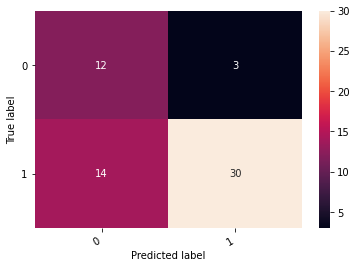

In [368]:
cm = confusion_matrix(y_true = y_test ,y_pred=X_test_pred_bal.y_pred)
DT2_model_cm = pd.DataFrame(cm, index= dt_model_bal.classes_, columns=dt_model_bal.classes_)
hmap = sns.heatmap(DT2_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [369]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_bal.y_pred))

              precision    recall  f1-score   support

           0       0.46      0.80      0.59        15
           1       0.91      0.68      0.78        44

    accuracy                           0.71        59
   macro avg       0.69      0.74      0.68        59
weighted avg       0.80      0.71      0.73        59



In [370]:
-cross_val_score(dt_model_bal, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([1.39506196, 0.40883689, 0.58643845, 0.45660032, 0.53638376,
       0.37564051, 0.50016669, 0.62802865, 2.27330784, 0.41513757,
       1.39506196, 1.39506196, 0.41513757, 0.54599165, 0.7931835 ,
       0.72854999, 1.44016862, 0.50016669, 0.37564051, 1.39506196,
       0.53051875, 1.35185151, 1.53666221, 0.56988806, 0.41513757,
       0.49381777])

In [371]:
dt_model_bal.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 40,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.01,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [372]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [373]:
dt_model_bal_gs = GridSearchCV(estimator=dt_model_bal,\
                           param_grid=my_param_grid, cv=my_cv, scoring='neg_log_loss')

In [374]:
dt_model_bal_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=26, random_state=990, test_size=None,
            train_size=0.75),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min...leaf=0.01,
                                              presort='deprecated',
                                              random_state=None,
                                    

In [375]:
print("Best parameters:", dt_model_bal_gs.best_params_)

Best parameters: {'criterion': 'gini', 'min_impurity_decrease': 1e-05, 'min_samples_leaf': 60, 'min_weight_fraction_leaf': 0.01}


In [376]:
dt_model_bal_gs_best = dt_model_bal_gs.best_estimator_

In [377]:
y_test_pred_bal = pd.DataFrame(dt_model_bal_gs_best.predict_proba(X_test),\
                              columns=dt_model_bal_gs_best.classes_)

In [378]:
log_loss(y_true=y_test, y_pred=y_test_pred_bal)

0.5629874386405868

## XGBoost

In [379]:
numSplits_XGB = 4
paramGrid_XGB = {'learning_rate': [ 0.15, 0.2, 0.25], \
             'n_estimators': [10, 50, 100], 'max_depth': [5,10,15]}

In [380]:
gsModel_XGB = GridSearchCV(estimator = xgb.XGBClassifier(scale_pos_weight=(48/147),\
      verbosity = 0, random_state = randState), param_grid = paramGrid_XGB, \
    scoring = 'precision', cv = numSplits_XGB) 

t1 = time()
gsModel_XGB.fit(X_train, y_train)
t2 = time()
print(f"XGBoost took {t2-t1:.2f} seconds")

XGBoost took 1.82 seconds


In [381]:
print("{:3} classifier:\n \
    \ttrain accuracy: {:.2f}\n \
    \ttest accuracy: {:.2f}"\
    .format('DT Gradient Boosting (XGBoost)', 
            accuracy_score(gsModel_XGB.predict(X_train), y_train), 
            accuracy_score(gsModel_XGB.predict(X_test), y_test)))

DT Gradient Boosting (XGBoost) classifier:
     	train accuracy: 0.96
     	test accuracy: 0.97


In [382]:
X_test_pred_XGB = X_test.copy()

X_test_pred_XGB['y_pred'] = gsModel_XGB.predict(X_test)
X_test_pred_XGB['y_train'] = y_test
X_test_pred_XGB.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
109,0.609511,0.217918,0.085328,0.189962,0.130435,0.184008,0.159164,0.184139,0.190798,0.156122,0.253467,0.168928,0.104526,0.253434,0.028074,0.548362,0.562283,0.662363,0.383277,0.613222,0.527372,0.292297,0.561856,1,1
168,0.635936,0.235733,0.145762,0.201715,0.130435,0.203276,0.190782,0.203243,0.111649,0.085456,0.158706,0.095251,0.055134,0.158685,0.040488,0.440055,0.269849,0.601316,0.402861,0.356254,0.649132,0.327943,0.865979,0,0
148,0.583838,0.233028,0.578638,0.492694,0.328063,0.447013,0.501072,0.446781,0.562717,0.523418,0.581471,0.544098,0.467494,0.581461,0.254767,0.156750,0.691351,0.755974,0.829452,0.740813,0.823704,0.774825,0.762887,1,1
126,0.289989,0.194113,0.090032,0.119441,0.130435,0.108863,0.125938,0.109006,0.167701,0.132293,0.198190,0.167571,0.117926,0.198164,0.055034,0.395716,0.855472,0.653223,0.438375,0.182097,0.177061,0.351131,0.649485,1,1
140,0.477581,0.340184,0.080987,0.128018,0.090909,0.078998,0.094855,0.078985,0.211703,0.161052,0.242296,0.189145,0.161192,0.242329,0.077028,0.410428,0.981287,0.441324,0.572802,0.881266,0.685321,0.481927,0.721649,1,1
5,0.187568,0.059232,0.278139,0.254130,0.288538,0.190270,0.352626,0.190079,0.342067,0.304848,0.360747,0.401085,0.193277,0.360829,0.036827,0.525766,0.370978,0.999128,0.672961,0.659218,0.339999,0.648753,0.025773,1,1


In [383]:
preds_XGB= gsModel_XGB.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_XGB)

0.990909090909091

Text(0.5, 15.0, 'Predicted label')

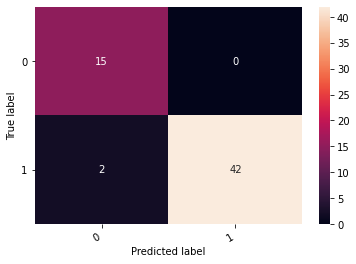

In [384]:
cm = confusion_matrix(y_true = y_test ,y_pred=X_test_pred_XGB.y_pred)
XGB_cm = pd.DataFrame(cm, index=gsModel_XGB.classes_, columns=gsModel_XGB.classes_)
hmap = sns.heatmap(XGB_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [385]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_XGB.y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.95      0.98        44

    accuracy                           0.97        59
   macro avg       0.94      0.98      0.96        59
weighted avg       0.97      0.97      0.97        59



In [386]:
gsModel_XGB.best_params_

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 10}

# Model 3 Random Forest

In [387]:
rf_model_1 = RandomForestClassifier(class_weight = 'balanced')

rf_model_1.fit(X_train,y_train)
preds= rf_model_1.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds)

0.9560606060606062

In [388]:
pd.Series(rf_model_1.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

12    0.099120
21    0.098655
18    0.071490
11    0.065858
22    0.065334
0     0.063030
10    0.049546
19    0.049145
9     0.048499
8     0.045901
6     0.039581
13    0.038122
20    0.037565
1     0.034736
7     0.034426
2     0.032385
5     0.023139
14    0.022843
15    0.019912
3     0.017288
4     0.015813
17    0.014304
16    0.013310
dtype: float64

In [389]:
y_train_pred = pd.DataFrame(rf_model_1.predict_proba(X_train), 
                            columns=rf_model_1.classes_)
y_train_pred.head()

,0,1
0,0.00,1.00
1,0.91,0.09
2,0.00,1.00
3,0.01,0.99
4,0.88,0.12


### Evaluate the model

In [390]:
X_test_pred_rf = X_test.copy()

X_test_pred_rf['y_pred'] = rf_model_1.predict(X_test)
X_test_pred_rf['y_train'] = y_test
X_test_pred_rf.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
113,0.709126,0.266514,0.689615,0.116264,0.090909,0.121869,0.100750,0.122010,0.066277,0.052588,0.078197,0.060651,0.044567,0.078251,0.017666,0.618955,0.430553,0.589516,0.361953,0.549299,0.474184,0.276015,0.582474,1,1
23,0.498242,0.184921,0.119198,0.097840,0.090909,0.073699,0.088960,0.073688,0.295600,0.229252,0.333590,0.257802,0.233785,0.333676,0.056498,0.486914,0.654938,0.448643,0.491092,0.459244,0.500128,0.432902,0.118557,1,1
150,0.572631,0.224167,0.483413,0.541296,0.367589,0.485067,0.569132,0.484990,0.445134,0.574363,0.432203,0.426594,0.424229,0.432148,0.346532,0.166138,0.586251,0.750755,0.629309,0.751841,0.683104,0.532173,0.773196,1,1
122,0.290251,0.206940,0.102848,0.170267,0.169960,0.162813,0.163987,0.162787,0.321800,0.292523,0.410632,0.270963,0.191515,0.410643,0.060572,0.400878,0.656693,0.666112,0.460354,0.346660,0.296793,0.383890,0.628866,1,1
64,0.821251,0.306349,0.896289,0.011753,0.007905,0.022158,0.011254,0.022154,0.045919,0.036154,0.060478,0.052510,0.022743,0.060598,0.007480,0.730472,0.047319,0.395823,0.084745,0.113840,0.257909,0.060150,0.329897,0,0
67,0.283143,0.131586,0.003040,0.239835,0.249012,0.211464,0.198821,0.211270,0.196914,0.183237,0.227851,0.161330,0.144268,0.227885,0.082567,0.468910,0.563634,0.616659,0.477388,0.448846,0.386264,0.376341,0.345361,1,1


Text(0.5, 15.0, 'Predicted label')

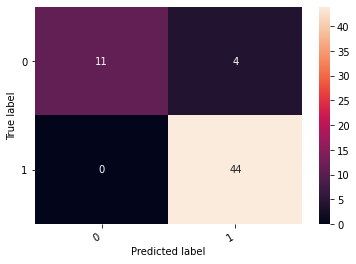

In [391]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred_rf.y_pred)
RF_cm = pd.DataFrame(cm, index=rf_model_1.classes_, columns=rf_model_1.classes_)
hmap = sns.heatmap(RF_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [392]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_rf.y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.92      1.00      0.96        44

    accuracy                           0.93        59
   macro avg       0.96      0.87      0.90        59
weighted avg       0.94      0.93      0.93        59



In [393]:
dt_model_bal_gs.best_params_

{'criterion': 'gini',
 'min_impurity_decrease': 1e-05,
 'min_samples_leaf': 60,
 'min_weight_fraction_leaf': 0.01}

In [394]:
rf_model_2 = RandomForestClassifier(**dt_model_bal_gs.best_params_)

In [395]:
my_param_grid = {'bootstrap': [True, False], 
                 'n_estimators': [25, 50], 
                 'oob_score': [True, False], 
                 'warm_start': [True, False]}

In [396]:
rf_model_gs = GridSearchCV(estimator=rf_model_2, param_grid=my_param_grid,\
                           scoring='accuracy', cv=my_cv)

In [397]:
t1 = time()
rf_model_gs.fit(X_train, y_train)
t2 = time()
print(f"It took {t2 - t1:.2f} seconds")

It took 18.21 seconds


In [398]:
print(rf_model_gs.score(X_train, y_train))
print(rf_model_gs.score(X_test, y_test))

0.7573529411764706
0.7457627118644068


In [399]:
bestModel = rf_model_gs.best_estimator_
bestModel.score(X_test, y_test)

0.7457627118644068

# Model 4 Logistic Regression

In [400]:
lr_model = LogisticRegression(class_weight='balanced', random_state = randState)
lr_model.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 990,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [401]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=990, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [402]:
X_test_pred_3 = X_test.copy()

X_test_pred_3['y_pred'] = lr_model.predict(X_test)
X_test_pred_3['y_train'] = y_test
X_test_pred_3.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
22,0.463388,0.185913,0.078253,0.087039,0.090909,0.073218,0.083065,0.073367,0.310115,0.239934,0.341487,0.267300,0.270082,0.341571,0.038673,0.570064,0.845791,0.420516,0.657035,0.576540,0.664403,0.499466,0.113402,1,1
75,0.130254,0.041777,0.227590,0.110546,0.169960,0.100674,0.105573,0.100658,0.115118,0.099425,0.159669,0.088060,0.076269,0.159648,0.012955,0.680972,0.482859,0.928006,0.449722,0.695153,0.195209,0.381264,0.386598,1,1
110,0.654245,0.248705,0.139383,0.143901,0.090909,0.145954,0.131297,0.145770,0.121599,0.100247,0.141949,0.117910,0.086760,0.141995,0.020339,0.601398,0.418857,0.611862,0.489367,0.563191,0.501664,0.389333,0.567010,1,1
168,0.635936,0.235733,0.145762,0.201715,0.130435,0.203276,0.190782,0.203243,0.111649,0.085456,0.158706,0.095251,0.055134,0.158685,0.040488,0.440055,0.269849,0.601316,0.402861,0.356254,0.649132,0.327943,0.865979,1,0
150,0.572631,0.224167,0.483413,0.541296,0.367589,0.485067,0.569132,0.484990,0.445134,0.574363,0.432203,0.426594,0.424229,0.432148,0.346532,0.166138,0.586251,0.750755,0.629309,0.751841,0.683104,0.532173,0.773196,1,1
23,0.498242,0.184921,0.119198,0.097840,0.090909,0.073699,0.088960,0.073688,0.295600,0.229252,0.333590,0.257802,0.233785,0.333676,0.056498,0.486914,0.654938,0.448643,0.491092,0.459244,0.500128,0.432902,0.118557,1,1


### Evaluate the model

Text(0.5, 15.0, 'Predicted label')

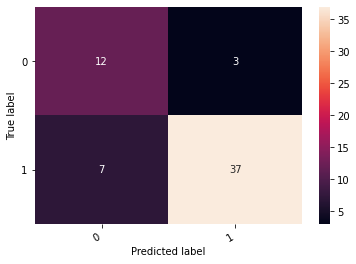

In [403]:
cm = confusion_matrix(y_true = y_test, y_pred=X_test_pred_3.y_pred)
LR_cm = pd.DataFrame(cm, index=lr_model.classes_, columns=lr_model.classes_)
hmap = sns.heatmap(LR_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [404]:
accuracy_score(y_true=y_test, y_pred=X_test_pred_3.y_pred)

0.8305084745762712

In [405]:
penalty = ['l1', 'l2']
C = np.logspace(0, 5, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [406]:
clr = GridSearchCV(lr_model, hyperparameters, cv=20, verbose=2, scoring='accuracy')

In [407]:
best_model_clr = clr.fit(X_train, y_train)
print('Best Penalty:', best_model_clr.best_estimator_.get_params()['penalty'])
print('Best C:', round(best_model_clr.best_estimator_.get_params()['C'],2))

Fitting 20 folds for each of 20 candidates, totalling 400 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    6.5s finished


In [408]:
y_pred_gs = best_model_clr.predict(X_test)
cm_gs = confusion_matrix(y_true = y_test, y_pred=y_pred_gs)

In [409]:
pd.DataFrame(cm_gs, index=best_model_clr.classes_, columns=best_model_clr.classes_)

,0,1
0,11,4
1,1,43


In [410]:
y_pred_lr = lr_model.predict(X_test)
cm_gs = confusion_matrix(y_true = y_test, y_pred=y_pred_gs)

In [411]:
print(classification_report(y_true=y_test,
                            y_pred=y_pred_gs))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.91      0.98      0.95        44

    accuracy                           0.92        59
   macro avg       0.92      0.86      0.88        59
weighted avg       0.92      0.92      0.91        59



In [412]:
accuracy_score(y_true=y_test, y_pred= y_pred_gs)

0.9152542372881356

In [413]:
Parkinsons_probs = pd.DataFrame(best_model_clr.predict_proba(X_train), \
                          columns=['P({})'.format(x) for x in best_model_clr.classes_], index=X_train.index)
X_train_1 = X_train.join(Parkinsons_probs)
X_train_1.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,P(0),P(1)
12,0.282892,0.117826,0.378827,0.039708,0.051383,0.024085,0.032690,0.024241,0.027844,0.022186,0.038713,0.019946,0.032238,0.038773,0.016424,0.701536,0.476059,0.289093,0.256346,0.329880,0.274923,0.194630,0.061856,3.611737e-03,0.996388
139,0.161941,0.060394,0.255271,0.067662,0.090909,0.054432,0.075027,0.054262,0.189155,0.149548,0.203968,0.168521,0.157056,0.204070,0.056084,0.421036,0.859210,0.485116,0.379433,0.510550,0.454813,0.290882,0.716495,5.371207e-05,0.999946
192,0.502730,0.281413,0.050727,0.378653,0.288538,0.267823,0.252947,0.267940,0.123608,0.140509,0.156587,0.107870,0.072594,0.156631,0.338988,0.383728,0.352318,0.324299,0.212945,0.342577,0.558967,0.180580,0.989691,9.922631e-01,0.007737
194,0.733274,0.322794,0.071948,0.126747,0.090909,0.109345,0.120579,0.109327,0.084900,0.086278,0.109977,0.080190,0.050080,0.110027,0.137919,0.518898,0.481200,0.358856,0.405161,0.415095,0.503673,0.215460,1.000000,9.710746e-01,0.028925
18,0.376738,0.150411,0.018118,0.182338,0.169960,0.142582,0.182208,0.142559,0.416560,0.375514,0.388290,0.407327,0.386553,0.388304,0.098514,0.359221,0.953724,0.578412,0.726078,0.791492,0.749921,0.689459,0.092784,0.000000e+00,1.000000
166,0.867371,0.288974,0.942923,0.042884,0.011858,0.050578,0.035906,0.050570,0.026292,0.025472,0.046418,0.024016,0.012482,0.046540,0.014896,0.659920,0.299355,0.208872,0.171205,0.382789,0.190899,0.097478,0.855670,9.999986e-01,0.000001
160,0.150810,0.045415,0.066473,0.131194,0.169960,0.111272,0.120043,0.111093,0.278894,0.263763,0.216487,0.193216,0.259974,0.216459,0.063914,0.487523,0.925307,0.479228,0.502445,0.569438,0.323789,0.415073,0.824742,4.642361e-07,1.000000
25,0.093537,0.212003,0.071920,0.147713,0.209486,0.119461,0.151661,0.119441,0.256801,0.243221,0.245955,0.227273,0.234398,0.246052,0.089824,0.553727,0.621063,0.652040,0.432681,0.519066,0.633081,0.362396,0.128866,3.298635e-10,1.000000
175,0.157459,0.042794,0.248471,0.052097,0.090909,0.044316,0.057342,0.044309,0.050119,0.042728,0.068760,0.049254,0.031702,0.068815,0.010695,0.713810,0.348641,0.744895,0.361277,0.431463,0.245375,0.288981,0.902062,7.019492e-01,0.298051
21,0.381593,0.144350,0.072841,0.099111,0.090909,0.078998,0.093783,0.078985,0.290579,0.234182,0.301618,0.274220,0.291447,0.301579,0.056785,0.449159,0.869024,0.496677,0.502269,0.520797,0.504589,0.445761,0.108247,2.863792e-09,1.000000


# Model 5 CATBoost 

In [414]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [415]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [416]:
cat_model = CatBoostClassifier(iterations=1000, depth=3, learning_rate=0.1, loss_function='Logloss')

In [417]:
t1 = time()

cat_model.fit(X_train, y_train,cat_features=categorical_features_indices,\
         eval_set=(X_test, y_test),use_best_model=True,plot=True)

print('CatBoost model is fitted: ' + str(cat_model.is_fitted()))
print('CatBoost model parameters:')
print(cat_model.get_params())

t2 = time()
print(f"CATBoost took {t2-t1:.2f} seconds")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5923793	test: 0.5857597	best: 0.5857597 (0)	total: 4.64ms	remaining: 4.63s
1:	learn: 0.5237895	test: 0.5396044	best: 0.5396044 (1)	total: 6.44ms	remaining: 3.21s
2:	learn: 0.4703300	test: 0.4884068	best: 0.4884068 (2)	total: 8.16ms	remaining: 2.71s
3:	learn: 0.4120279	test: 0.4338961	best: 0.4338961 (3)	total: 9.27ms	remaining: 2.31s
4:	learn: 0.3608858	test: 0.3848331	best: 0.3848331 (4)	total: 10.4ms	remaining: 2.06s
5:	learn: 0.3327599	test: 0.3625401	best: 0.3625401 (5)	total: 11.4ms	remaining: 1.89s
6:	learn: 0.3120940	test: 0.3359474	best: 0.3359474 (6)	total: 12.8ms	remaining: 1.82s
7:	learn: 0.2868013	test: 0.3122648	best: 0.3122648 (7)	total: 15ms	remaining: 1.86s
8:	learn: 0.2503817	test: 0.2723263	best: 0.2723263 (8)	total: 16.2ms	remaining: 1.79s
9:	learn: 0.2280310	test: 0.2624327	best: 0.2624327 (9)	total: 17.8ms	remaining: 1.76s
10:	learn: 0.2125772	test: 0.2520610	best: 0.2520610 (10)	total: 18.9ms	remaining: 1.7s
11:	learn: 0.1989862	test: 0.2316972	best: 0

### Evaluate the model

In [418]:
# predict the target on the train dataset
predict_train = cat_model.predict(X_train)
print('\nTarget on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = cat_model.predict(X_test)
print('\nTarget on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)



Target on train data [1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]

accuracy_score on train dataset :  1.0

Target on test data [1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0]

accuracy_score on test dataset :  0.9830508474576272


Text(0.5, 15.0, 'Predicted label')

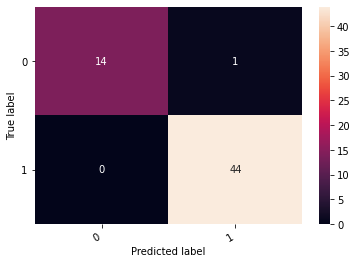

In [419]:
cm = confusion_matrix(y_true = y_test ,y_pred = predict_test)
XGB_cm = pd.DataFrame(cm, index=cat_model.classes_, columns=cat_model.classes_)
hmap = sns.heatmap(XGB_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [428]:
-cross_val_score(cat_model, X_train, y_train, cv=my_cv, scoring='accuracy') 

Streaming output truncated to the last 5000 lines.
0:	learn: 0.6190186	total: 915us	remaining: 914ms
1:	learn: 0.5557093	total: 1.81ms	remaining: 903ms
2:	learn: 0.5071600	total: 2.68ms	remaining: 892ms
3:	learn: 0.4289083	total: 3.54ms	remaining: 881ms
4:	learn: 0.3831773	total: 4.48ms	remaining: 892ms
5:	learn: 0.3467836	total: 5.38ms	remaining: 892ms
6:	learn: 0.3130211	total: 6.28ms	remaining: 891ms
7:	learn: 0.2872398	total: 7.2ms	remaining: 893ms
8:	learn: 0.2534303	total: 8.08ms	remaining: 890ms
9:	learn: 0.2277234	total: 8.96ms	remaining: 887ms
10:	learn: 0.2147943	total: 9.81ms	remaining: 882ms
11:	learn: 0.1937787	total: 10.7ms	remaining: 878ms
12:	learn: 0.1833693	total: 11.5ms	remaining: 876ms
13:	learn: 0.1706589	total: 12.4ms	remaining: 875ms
14:	learn: 0.1637993	total: 13.3ms	remaining: 872ms
15:	learn: 0.1570404	total: 14.2ms	remaining: 872ms
16:	learn: 0.1448097	total: 15ms	remaining: 869ms
17:	learn: 0.1411565	total: 15.9ms	remaining: 868ms
18:	learn: 0.1336121	total:

array([-0.97058824, -0.97058824, -1.        , -1.        , -0.94117647,
       -0.97058824, -1.        , -1.        , -0.91176471, -1.        ,
       -0.94117647, -0.94117647, -0.94117647, -0.97058824, -1.        ,
       -1.        , -0.91176471, -0.85294118, -0.94117647, -0.97058824,
       -1.        , -0.97058824, -0.94117647, -1.        , -0.97058824,
       -0.94117647])

In [425]:
parameters = {'depth'         : [3,4,5,6,7,8,9,10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10,50,100,500,1000]}

In [426]:
t1 = time()

Grid_cat_model = GridSearchCV(estimator=cat_model, param_grid = parameters, cv = 3, n_jobs=-1)
Grid_cat_model.fit(X_train, y_train)

print('CatBoost model is fitted: ' + str(cat_model.is_fitted()))
print('CatBoost model parameters:')
print(cat_model.get_params())

t2 = time()
print(f"CATBoost took {t2-t1:.2f} seconds")

0:	learn: 0.6820185	total: 1.18ms	remaining: 588ms
1:	learn: 0.6731410	total: 2.21ms	remaining: 550ms
2:	learn: 0.6644088	total: 3.2ms	remaining: 531ms
3:	learn: 0.6527625	total: 4.2ms	remaining: 521ms
4:	learn: 0.6425188	total: 5.19ms	remaining: 513ms
5:	learn: 0.6323494	total: 6.16ms	remaining: 508ms
6:	learn: 0.6257813	total: 7.15ms	remaining: 504ms
7:	learn: 0.6186625	total: 8.12ms	remaining: 499ms
8:	learn: 0.6057819	total: 9.1ms	remaining: 497ms
9:	learn: 0.5986156	total: 10.1ms	remaining: 495ms
10:	learn: 0.5904104	total: 11.1ms	remaining: 492ms
11:	learn: 0.5809767	total: 12.1ms	remaining: 490ms
12:	learn: 0.5753524	total: 13ms	remaining: 488ms
13:	learn: 0.5646659	total: 14ms	remaining: 485ms
14:	learn: 0.5562015	total: 14.9ms	remaining: 483ms
15:	learn: 0.5513406	total: 15.9ms	remaining: 481ms
16:	learn: 0.5422634	total: 16.9ms	remaining: 480ms
17:	learn: 0.5362207	total: 17.9ms	remaining: 478ms
18:	learn: 0.5283021	total: 18.8ms	remaining: 476ms
19:	learn: 0.5246605	total: 1

GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f4eb48e0ad0>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 50, 100, 500, 1000],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [427]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_cat_model.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_cat_model.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_cat_model.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9705314009661836

 The best parameters across ALL searched params:
 {'depth': 3, 'iterations': 500, 'learning_rate': 0.01}
